In [220]:
import numpy as np
import pandas as pd
pd.set_option("precision", 3)
import matplotlib.pyplot as plt
from funcs.fitting import loss_single_seg
from datetime import datetime
from funcs.models import model_ND
from scipy.optimize import minimize

In [322]:
df = pd.read_csv('data/stoke_delta_t.csv', comment='#')
df = df.dropna() 
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df['timestamp'] = df['time'].values.astype(np.int64)//10**9 # Add a timestamp column, measured in seconds
cols = ['outside','1N','2N','3N','4N','BMS'] # select a subset of columns
df['gas'] *= 4e4/(3600) # convert kW*h to W*s (factor of 2 for 1/2 hour?)
df.describe()

,outside,1N,1S,2N,2S,3N,3S,4N,4S,BMS,gas,timestamp
count,3336.000,3336.00,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3336.000,3.336e+03
mean,6.143,18.75,20.830,21.625,22.438,21.521,21.609,21.072,20.984,21.109,901.549,1.580e+09
std,2.190,1.14,1.001,0.772,0.892,0.926,0.835,0.972,0.943,0.750,345.598,1.734e+06
min,-0.100,16.70,17.100,20.000,20.000,19.800,19.900,17.500,17.500,19.100,0.000,1.577e+09
25%,4.700,17.80,20.100,21.200,21.800,21.000,21.100,20.300,20.200,20.500,755.556,1.578e+09
50%,6.300,18.80,20.700,21.700,22.400,21.600,21.600,21.100,20.900,21.100,877.778,1.580e+09
75%,7.600,19.50,21.400,22.200,23.100,22.200,22.200,21.800,21.700,21.625,1077.778,1.581e+09
max,11.400,22.50,24.100,23.600,24.800,23.800,24.000,23.700,23.600,23.400,2877.778,1.583e+09


#### Below is all temperature readings stacked, between 2019-12-19 and 2019-12-30

[Text(0, 0.5, 'Temperature (C)'), (18249.0, 18260.0)]

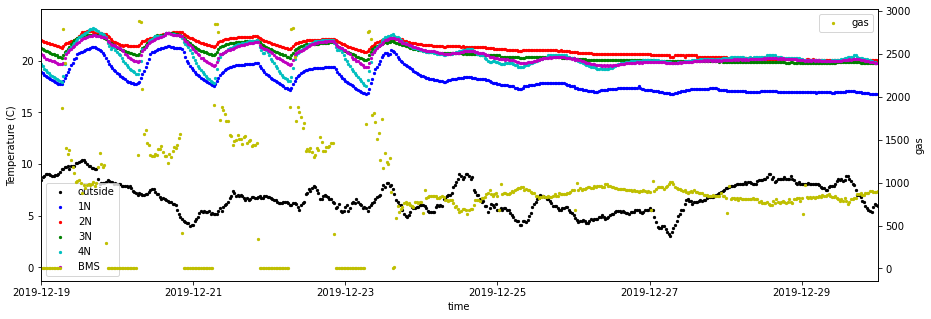

In [323]:
# define two time ranges to plot over
fmt = '%Y-%m-%dT%H:%M:%S.%f'
xlim1 = [datetime.strptime(time, fmt) for time in ['2020-02-13T00:00:00.00','2020-02-15T00:00:00.00']]
xlim2 = [datetime.strptime(time, fmt) for time in ['2019-12-19T00:00:00.00','2019-12-30T00:00:00.00']]
fig, ax = plt.subplots(1,1, figsize=(15,5))
colors = 'kbrgcm'
for i, col in enumerate(cols):
    df.plot(x='time', y=col, kind='scatter', s=5, ax=ax, label=col, color=colors[i])
ax2 = ax.twinx()
df.plot(x='time', y='gas', kind='scatter', s=5, ax=ax2, color='y', label='gas')
ax.set(ylabel = 'Temperature (C)', xlim=xlim2) 
# ax.legend()

## Modelling data for room 1 with our single segment model

In [324]:
times, Ts_true, Q_in, T_out = df[['timestamp','1N','gas','outside']].head(300).values.T
times = (times-times[0])

In [325]:
# Initial guesses for scipy.optimize.minimize
k0 = 100.0
c0 = 2e7
T0 = 18.9
initial_params = np.array([k0, c0, T0])

In [326]:
# Initialise class with system parameters
sys_guess = model_ND('Initial guess', k0, c0, T0, T_out, Q_in)

T_guess = sys_guess.run(times=times).flatten()

	Initial			Estimated
k1:	100.00000		77.97359
c1:	20,000,000.00		20,000,000.00
T1:	18.90000		19.95469


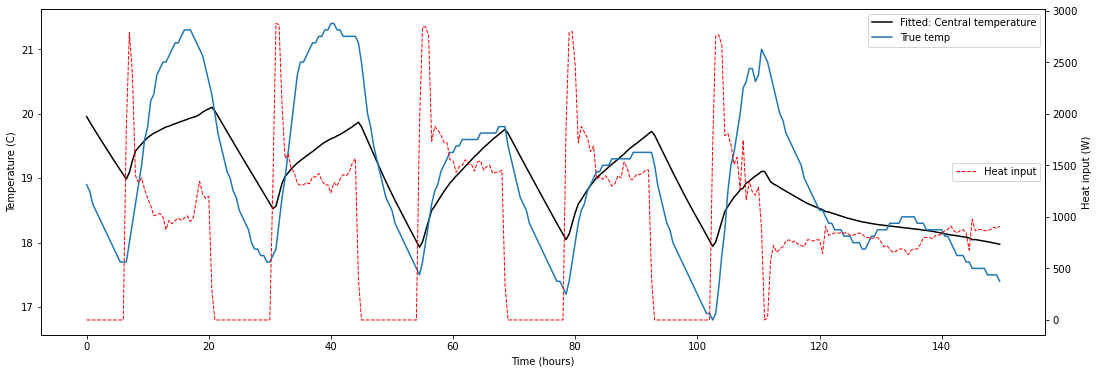

In [327]:
result = minimize(loss_single_seg, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((5e1,1e2),(1.5e7,2.5e7),(15,25)))
k_est, c_est, T_est = result['x']
print('\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}\nT1:\t{:,.5f}\t\t{:,.5f}'.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts = sys_fit.run(times=times).flatten()


fig, ax = sys_fit.plot()
sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
# ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 2 with our single segment model

In [328]:
times, Ts_true, Q_in, T_out = df[['timestamp','2N','gas','outside']].head(300).values.T
times = (times-times[0])

In [329]:
# Initial guesses for scipy.optimize.minimize
k0 = 100.0
c0 = 2e7
T0 = 18.9
initial_params = np.array([k0, c0, T0])

	Initial			Estimated
k1:	100.00000		61.91281
c1:	20,000,000.00		20,000,000.00
T1:	18.90000		22.49786


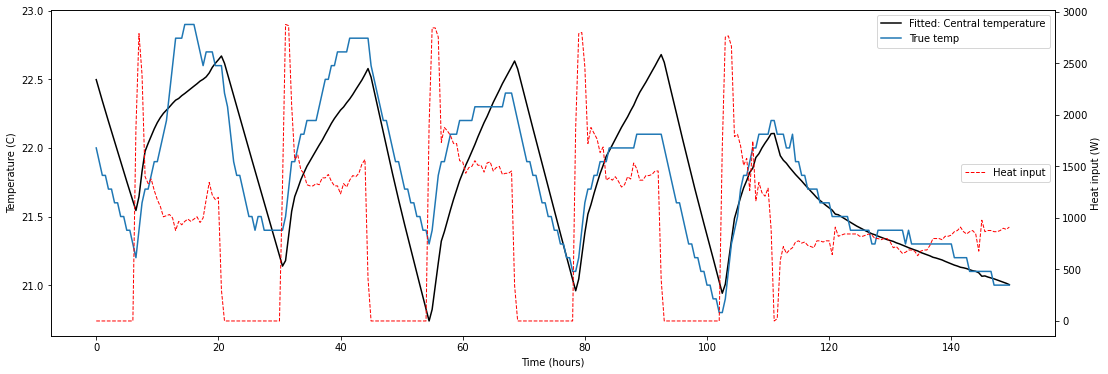

In [330]:
result = minimize(loss_single_seg, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((5e1,1e2),(1.5e7,2.5e7),(10,30)))
k_est, c_est, T_est = result['x']
print('\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}\nT1:\t{:,.5f}\t\t{:,.5f}'.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
T_out = np.full(300,)
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
# ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 3 with our single segment model

In [331]:
times, Ts_true, Q_in, T_out = df[['timestamp','3N','gas','outside']].head(300).values.T
times = (times-times[0])

In [332]:
# Initial guesses for scipy.optimize.minimize
k0 = 100.0
c0 = 2e7
T0 = 18.9
initial_params = np.array([k0, c0, T0])

	Initial			Estimated
k1:	100.00000		64.44671
c1:	20,000,000.00		20,000,000.00
T1:	18.90000		22.02002


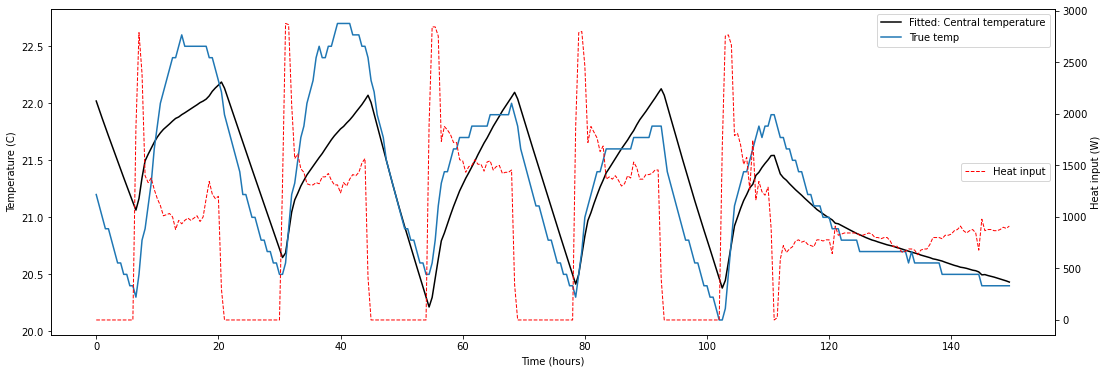

In [333]:
result = minimize(loss_single_seg, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((5e1,1e2),(1.5e7,2.5e7),(10,30)))
k_est, c_est, T_est = result['x']
print('\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}\nT1:\t{:,.5f}\t\t{:,.5f}'.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
# ax.plot(times/3600, T_out, label='Outside')
ax.legend();

## Modelling data for room 4 with our single segment model

In [334]:
times, Ts_true, Q_in, T_out = df[['timestamp','4N','gas','outside']].head(300).values.T
times = (times-times[0])

In [343]:
# Initial guesses for scipy.optimize.minimize
k0 = 100.0
c0 = 0.8e7 # Minimizer isn't able to find that lower c is better for room 4. Have to change it manually.
T0 = 18.9
initial_params = np.array([k0, c0, T0])

	Initial			Estimated
k1:	100.00000		64.23317
c1:	8,000,000.00		8,000,000.00
T1:	18.90000		21.18302


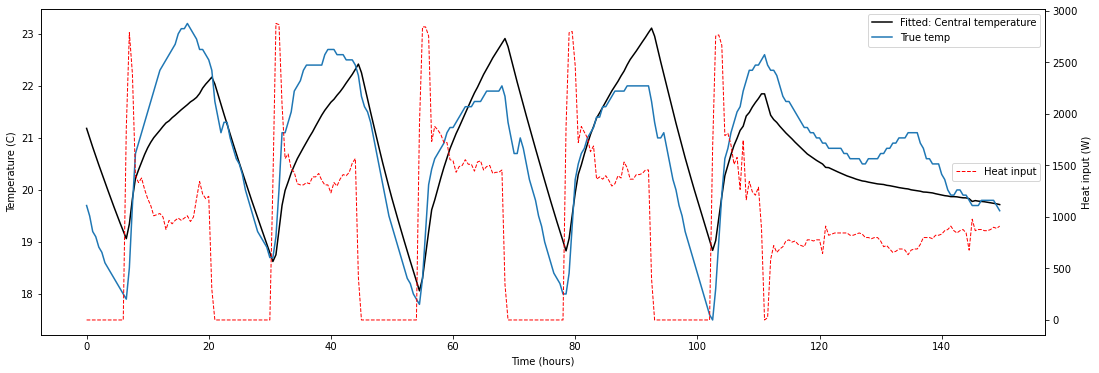

In [344]:
result = minimize(loss_single_seg, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true, T_out, Q_in), bounds=((5e1,2e2),(0.8e7,2e7),(10,30)))
k_est, c_est, T_est = result['x']
print('\tInitial\t\t\tEstimated\nk1:\t{:,.5f}\t\t{:,.5f}\nc1:\t{:,.2f}\t\t{:,.2f}\nT1:\t{:,.5f}\t\t{:,.5f}'.format(*np.ravel([initial_params,result['x']],'F')))

# Initialise class with system parameters
sys_fit = model_ND('Fitted', k_est, c_est, T_est, T_out, Q_in)
# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
Ts = sys_fit.run(times=times).flatten()

fig, ax = sys_fit.plot()
# sys_guess.plot(figax=figax, ls='-.');
ax.plot(times/3600, Ts_true, label='True temp')
# ax.plot(times/3600, T_out, label='Outside')
ax.legend();